# Телеком - Отток клиентов

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на `1 февраля 2020`.

- `BeginDate` - дата начала пользования услугами
- `EndDate` - дата окончания пользования услугами 
- `Type` - тип оплаты: ежемесячный, годовой и т.д.
- `PaperlessBilling` - электронный платежный документ
- `PaymentMethod` - способ оплаты
- `MonthlyCharges` - ежемесячные траты на услуги по договору
- `TotalCharges` - всего потрачего денег на услуги
- `Dependents` - наличие иждивенцев
- `Senior Citizen` - наличие пенсионного статуса по возрасту
- `Partner` - наличие супруга
- `MultipleLines` - наличие возможности ведения параллельных линий во время звонка

### Цель  проекта

Целью проекта является создание прогностической модели, способной предсказывать вероятность оттока клиентов. Модель будет основана на данных представленных заказчиком о клиентах и их поведении, а также на соответствующих переменных, связанных с услугами, активностью и удовлетворенностью клиентов. При достижении данной цели модель сможет:

- Идентифицировать клиентов, у которых высокая вероятность оттока.
- Предоставлять бизнесу ценную информацию о факторах, влияющих на отток клиентов.
- Повысить эффективность управления клиентской базой и удержания клиентов.
- Увеличить уровень удовлетворенности клиентов и общую прибыль компании.

### Задачи проекта

- Загрузить данные
- Подготовить данные
- Провести EDA
- Построить модели
- Выбор лучшей модели
- Финальный отчет

### План проекта

1. Загрузка и первичный осмотр данных
    - загрузка и осмотр данных методами библиотеки pandas
    - описание выводов
2. Исследовательский анализ данных
    - Предобработка данных
        - объединение таблиц в единую 
        - заполнение пропусков 
        - анализ некорректных данных
        - приведение столбцов к корректному типу данных  
        - добавление признаков (в том числе целевого признака)
        - удаление лишних признаков
    - Построение графиков и матрицы корреляции
        - построение графиков и матриц 
        - написание выводов к результатам
3. Обучение модели
    - Подготовка признаков
        - разделение на признаки и целевой признак
        - разделение данных на выборки 
        - кодировка категориальных признаков
        - масштабирование признаков (при необходимости)
        - борьба с дисбалансом
    - Обучение моделей
        - подбор гиперпараметров с помощью GridSearchCV, RandomizedSearchCV или Optuna
        - обучение нескольких моделей 
        - выявление лучшей модели с помощью кросс-валидации 
4. Тестирование модели
    - итоговое тестирование лучшей модели на тестовой выборке 
    - сравнение результатов со случайными или статичными моделями
    - подведение итогов и написание общего вывода
5. Подготовка отчета для бизнеса


Импортируем библиотеки

In [1]:
import os
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from phik import phik_matrix
from catboost import CatBoostClassifier
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score
)
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    roc_curve,
    confusion_matrix
)


Функции которые будем использовать в проекте 

- функция для вывода общей информации (на вход принимает датафрейм, выводит `head`, `info`, `describe`, `количество пропусков`, `количество дубликатов`

In [2]:
def data_info_describe(data):
    display(data.head())
    data.info()
    display(data.describe(include='all'))
    print('Пропуски:')
    print(data.isna().sum())
    print('_____________________')
    print(f'Дубликаты: {data.duplicated().sum()}')

- функция для приведения названия колонок к змеиному регистру (на `вход` список с `названиями колонок`, на `выходе список колонок приведенные к змеиному регистру`)

In [3]:
def convert_columns_to_snake_case(column_names):
    snake_case_columns = []
    for column_name in column_names:
        snake_case_column = ""
        if column_name == 'customerID':
            snake_case_columns.append('customer_id')
            continue
        if column_name == 'StreamingTV':
            snake_case_columns.append('streaming_tv')
            continue
        for index in range(len(column_name)):
            if index > 0 and column_name[index].isupper():
                snake_case_column += '_'
            snake_case_column += column_name[index].lower()
        snake_case_columns.append(snake_case_column)
    return snake_case_columns

# 1. Загрузка и первичный осмотр данных

Сохраним исходные данные в переменные: `contract`, `internet`, `personal`, `phone`

In [4]:
file_list = ['contract_new.csv', 'internet_new.csv', 'personal_new.csv', 'phone_new.csv']

data_array = []

for filename in file_list:
    
    if os.path.exists(filename):
        data_array.append(pd.read_csv(filename))
        
    elif os.path.exists('/datasets/' + filename):
        data_array.append(pd.read_csv('/datasets/' + filename))
        
    else:
        print('Что-то пошло не так')

In [5]:
contract, internet, personal, phone = data_array

Осмотрим данные и общую информацию в датафрейме:
- `contract`

In [6]:
data_info_describe(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,6259-WJQLC,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


Пропуски:
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
_____________________
Дубликаты: 0


- `internet`

In [7]:
data_info_describe(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,6259-WJQLC,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Пропуски:
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
_____________________
Дубликаты: 0


- `personal`

In [8]:
data_info_describe(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,6259-WJQLC,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


Пропуски:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
_____________________
Дубликаты: 0


- `phone`

In [9]:
data_info_describe(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,6259-WJQLC,No
freq,1,3390


Пропуски:
customerID       0
MultipleLines    0
dtype: int64
_____________________
Дубликаты: 0


# Вывод

В результате первичного осмотра данных было выявлено следующее:
- в каждой таблице по отдельности нет пропущенных значений
- отсутствуют дубликаты
- бóльшая часть категориальных признаков имеет только два уникальных значения  
- количество записей в таблицах различаются
- некоторые типы данных не соответствуют содержимому (например `TotalCharges` из таблицы `contract` содержит в себе числовые значения, но тип данных `object`; столбцы с `датами` так же имеют тип данных `object` и т.д.)

Переходим к предобработке данных

# 2. Исследовательский анализ данных 

## 2.1 Предобработка данных

Объединим наши таблицы в одну по столбцу `customerID`. Воспользуемся методом  `.merge()` с параметром  `how='outer'` , чтобы в нашу конечную таблицу попали все имеющиеся данные из всех таблиц. В случае если данных в какой-то таблице по полю `customerID` не окажется, такие ячейки будут заполнены пропусками

Объединим данные поэтапно. В начале объединим `contract` и `personal`. Далее к ним присоединим `internet`. Последним присоединим таблицу `phone` и сохраним объединенные данные в переменную `united_data`

In [10]:
buffer_data = pd.merge(contract, personal, on='customerID', how='outer')
buffer_data = pd.merge(buffer_data, internet, on='customerID', how='outer')

In [11]:
united_data = pd.merge(buffer_data, phone, on='customerID', how='outer')

Воспользовавшись созданной нами функцией приведем названия колонок объединенных данных к стилю `snake_case`

In [12]:
united_data.columns = convert_columns_to_snake_case(united_data.columns)

Взглянем на общую информацию объединенных данных

In [13]:
data_info_describe(united_data)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
count,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,5517,5517,5517,5517,5517,5517,5517,6361
unique,7043,77,67,3,2,4,NaN,6658,2,NaN,2,2,2,2,2,2,2,2,2,2
top,6259-WJQLC,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,,Male,NaN,No,No,Fiber optic,No,No,No,No,No,No,No
freq,1,366,5942,3875,4171,2365,NaN,11,3555,NaN,3641,4933,3096,3498,3088,3095,3473,2810,2785,3390
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN,0.162147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN,0.368612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Пропуски:
customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64
_____________________
Дубликаты: 0


Ожидаемо, появились пропуски. Возникли они в связи с тем что клиент не пользуется той или иной услугой. Соответственно, так и заполним пропуски.

Посмотрим на уникальные значения столбцов с пропусками 

In [14]:
nan_columns = ['internet_service', 'online_security', 'online_backup',
               'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
               'multiple_lines']
for column in nan_columns:
    print(column)
    print(united_data[column].unique())
    print('________________________________')

internet_service
['DSL' 'Fiber optic' nan]
________________________________
online_security
['No' 'Yes' nan]
________________________________
online_backup
['Yes' 'No' nan]
________________________________
device_protection
['No' 'Yes' nan]
________________________________
tech_support
['No' 'Yes' nan]
________________________________
streaming_tv
['No' 'Yes' nan]
________________________________
streaming_movies
['No' 'Yes' nan]
________________________________
multiple_lines
[nan 'No' 'Yes']
________________________________


Заполним пропущенные данные, значением`'No'`, тем самым обозначим отсутствие данной услуги у пользователя 

In [15]:
united_data = united_data.fillna('No')

Создадим, на основании столбца `end_data`, новый столбец `is_churn`. Который станет нашим целевым признаком и будет сигнализировать об оттоке клиента.

In [16]:
united_data['is_churn'] = united_data['end_date'].apply(lambda x: 0 if x == 'No' else 1)

Признаки `begin_date` и `end_date` можно заменить на продолжительность договора. Для этого нам нужно заменить значение `'No'` в `end_date` и привести столбцы к типу `datetime`

Из описания проекта нам известно что информация о договорах актуальна на `1 февраля 2020`. Соответственно значения `'No'` можно заменить на эту дату.

In [17]:
united_data['end_date'] = united_data['end_date'].replace('No', '2020-02-01')

Теперь приведем столбцы к типу `datetime`

In [18]:
united_data['end_date'] = pd.to_datetime(united_data['end_date'])
united_data['begin_date'] = pd.to_datetime(united_data['begin_date'])

Создадим новый столбец `contract_duration_days`, который будет показывать разницу между концом и началом контракта в днях, приведенный к типу **int**

In [19]:
united_data['contract_duration_days'] = ((united_data['end_date'] - united_data['begin_date'])
                                         .astype('timedelta64[D]')
                                         .astype(int))

От столбцов `begin_date` и `end_date` можно избавиться 

In [20]:
united_data = united_data.drop(['end_date', 'begin_date'], axis=1)

В столбце `total_charges` есть пустые значения ' '. Взглянем на строки с такими значениями 

In [21]:
united_data[['monthly_charges', 'total_charges', 'contract_duration_days']][united_data['total_charges'] == ' ']

,monthly_charges,total_charges,contract_duration_days
488,52.55,,0
753,20.25,,0
936,80.85,,0
1082,25.75,,0
1340,56.05,,0
3331,19.85,,0
3826,25.35,,0
4380,20.00,,0
5218,19.70,,0
6670,73.35,,0


Таких значений не много и наблюдаем что количество дней контракта в таких строках = 0. Видимо данные еще не успели сформироваться. Для заполнения пустых значений возьмем данные из столбца `monthly_charges`

In [22]:
united_data.loc[united_data['total_charges'] == ' ', 'total_charges'] = \
united_data.loc[united_data['total_charges'] == ' ', 'monthly_charges']

Теперь приведем столбец `total_charges` к типу данных `float`

In [23]:
united_data['total_charges'] = united_data['total_charges'].astype(float) 

Так-как данные уже объединены по столбцу`customer_id`, то его можно удалить. Никакой другой пользы от данного столбца уже не получим 

In [24]:
united_data = united_data.drop('customer_id', axis=1)

С числовыми данными разобрались. Посмотрим на уникальные значения всех категориальных признаков

In [25]:
cat_columns = ['type', 'paperless_billing', 'payment_method', 
               'gender', 'senior_citizen', 'partner', 'dependents',
               'internet_service', 'online_security', 'online_backup',
               'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
               'multiple_lines', 'is_churn']

In [26]:
for column in cat_columns:
    print(column)
    print(united_data[column].unique())
    print('________________________________')

type
['Month-to-month' 'One year' 'Two year']
________________________________
paperless_billing
['Yes' 'No']
________________________________
payment_method
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
________________________________
gender
['Female' 'Male']
________________________________
senior_citizen
[0 1]
________________________________
partner
['Yes' 'No']
________________________________
dependents
['No' 'Yes']
________________________________
internet_service
['DSL' 'Fiber optic' 'No']
________________________________
online_security
['No' 'Yes']
________________________________
online_backup
['Yes' 'No']
________________________________
device_protection
['No' 'Yes']
________________________________
tech_support
['No' 'Yes']
________________________________
streaming_tv
['No' 'Yes']
________________________________
streaming_movies
['No' 'Yes']
________________________________
multiple_lines
['No' 'Yes']
_______________________

В признаках отсутствуют некорректные или пустые значения. Можем переходить к следующему этапу

## 2.2 Графики и корреляция

Оценим корреляцию признаков с помощью библиотеки `phik`.

В переменную `interval_cols` сохраним наши не категориальные признаки (числовые непрерывные). Саму матрицу корреляции сохраним в переменную `correlation_matrix`

In [27]:
interval_cols = ['monthly_charges', 'total_charges', 'contract_duration_days']

correlation_matrix = phik_matrix(united_data, interval_cols=interval_cols)

Построим `heatmap` по нашей матрице 

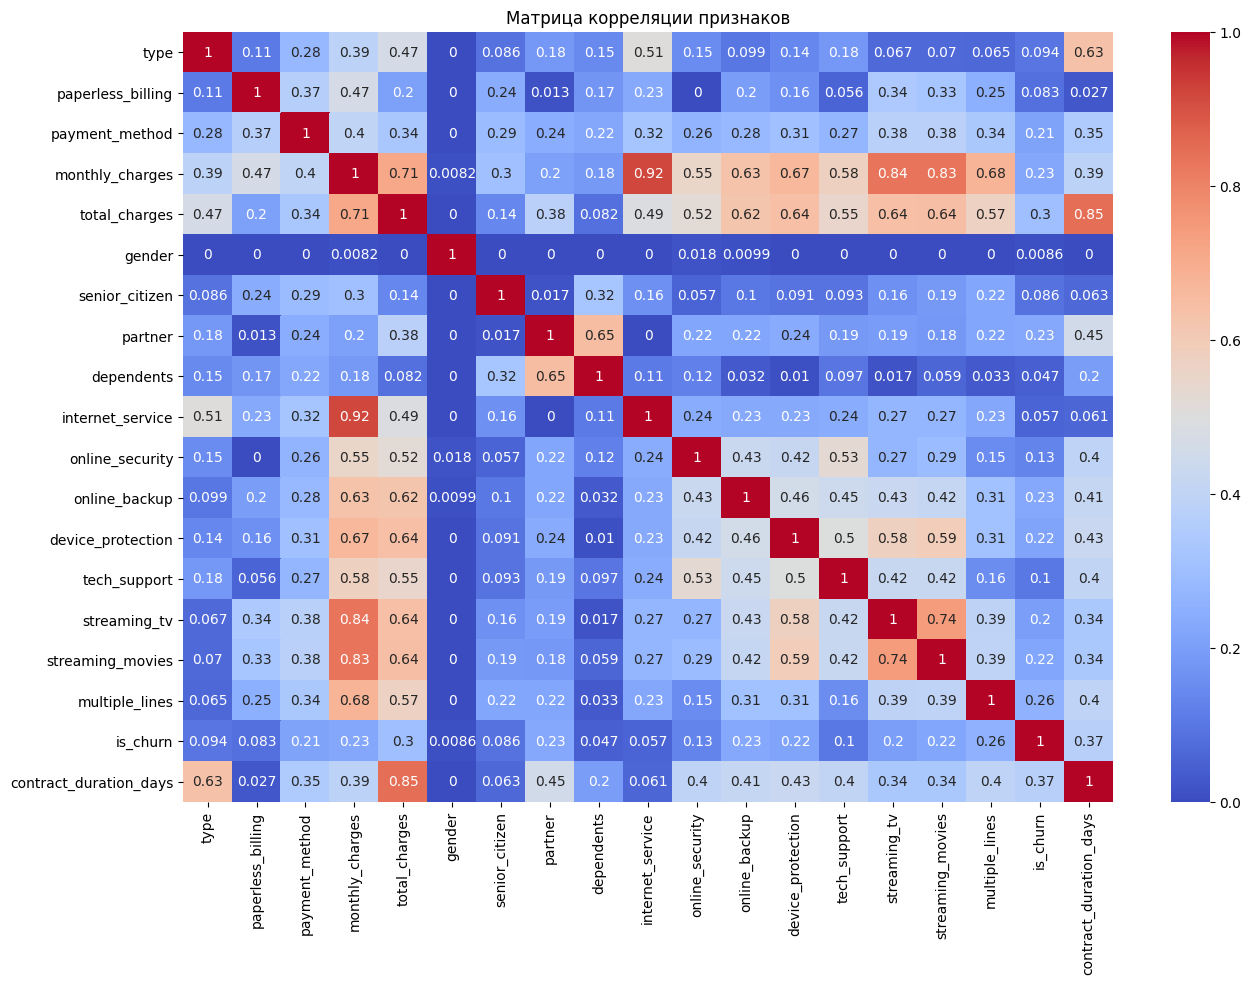

In [28]:
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции признаков')
plt.show()

На визуализации хорошо видно что признак `gender` имеет близкую к нулю корреляцию со всеми признаками, включая целевой признак.

Оперируя логикой, можно сказать, что пол никак не связан с оттоком. В связи с этим и данными, полученными при анализе корреляции, признак `gender` можно удалить 

In [29]:
united_data = united_data.drop('gender', axis=1)

Важность оставшихся признаков оценим на этапе построения моделей

Удалим из списка категориальных переменных `gender` и `is_churn`

In [30]:
cat_columns.remove('gender')
cat_columns.remove('is_churn')

Построим графики распределения по целевому признаку для категориальных переменных

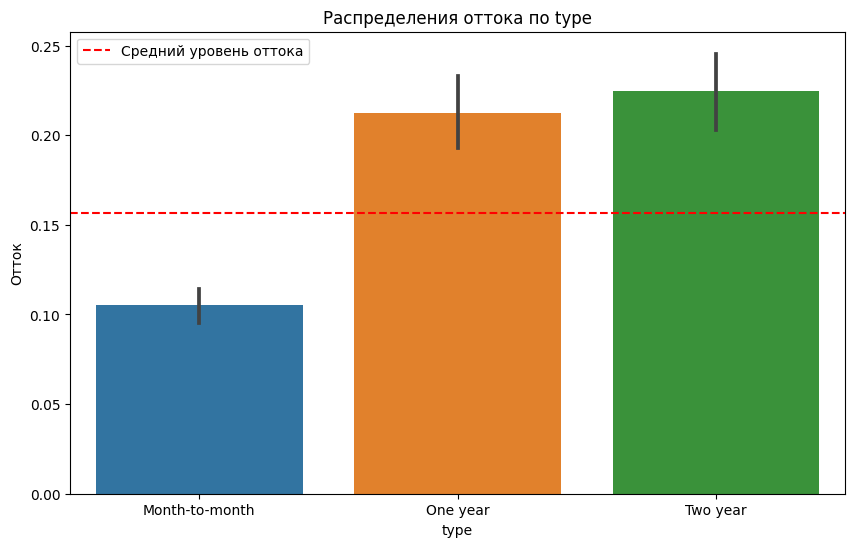

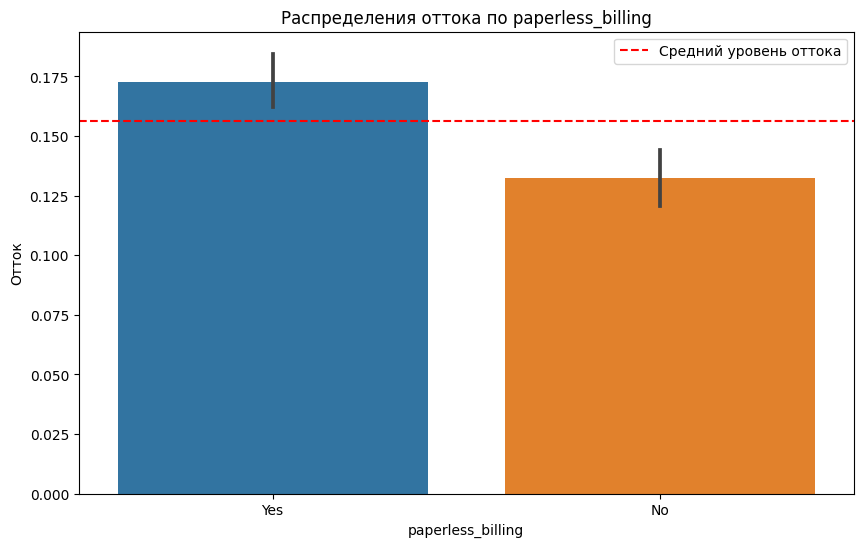

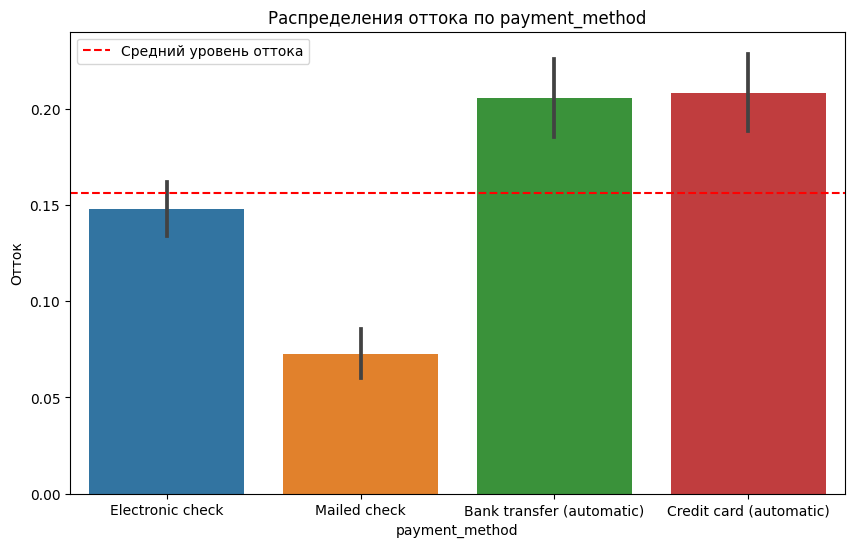

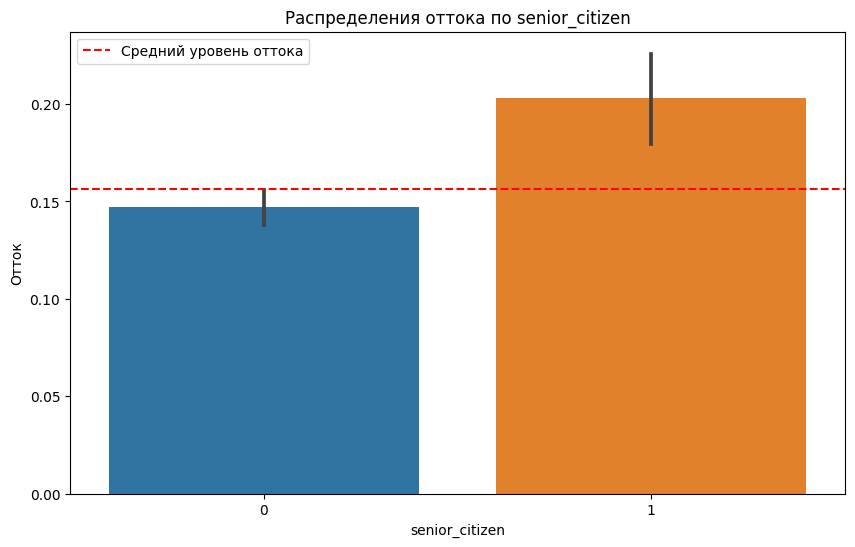

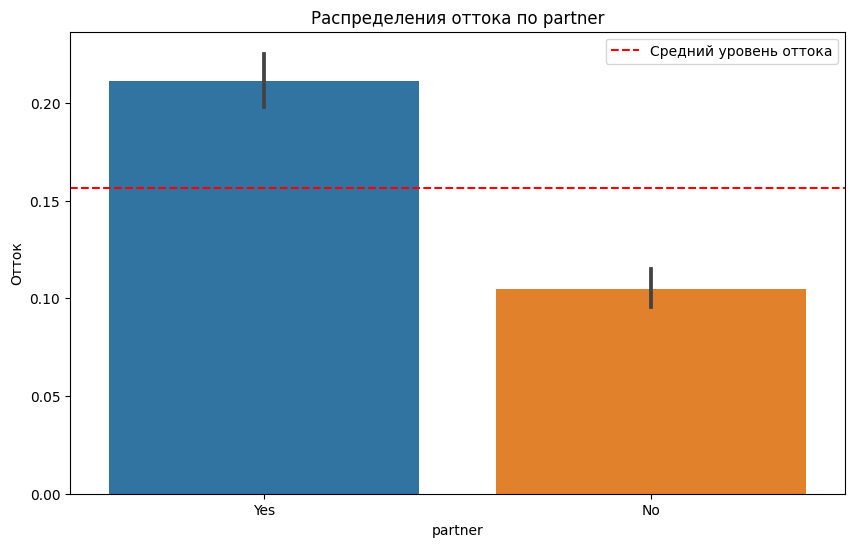

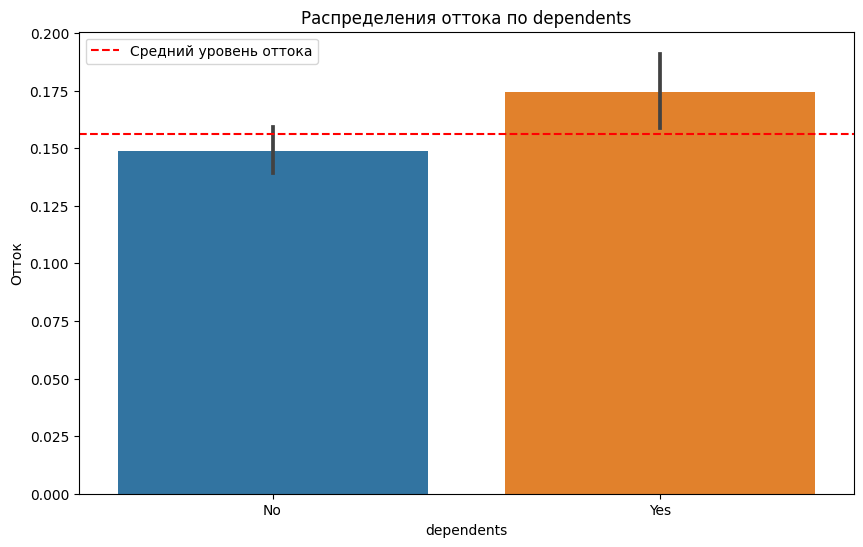

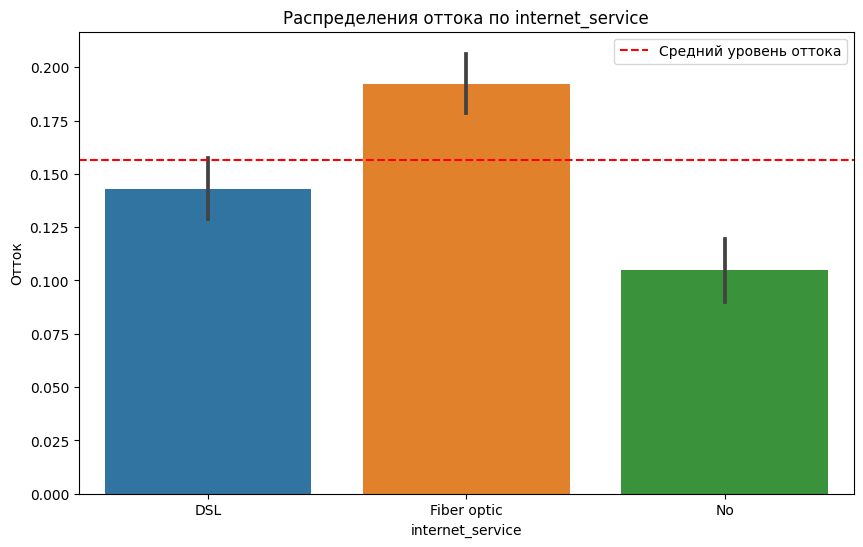

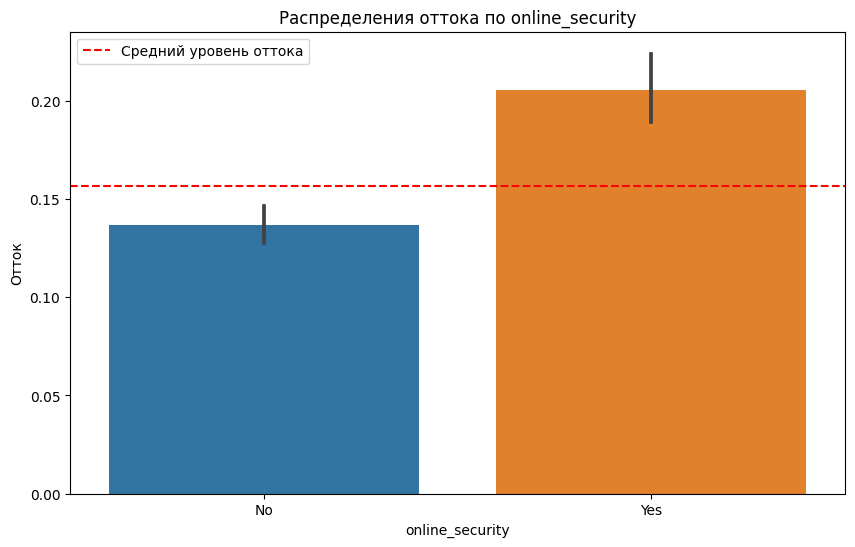

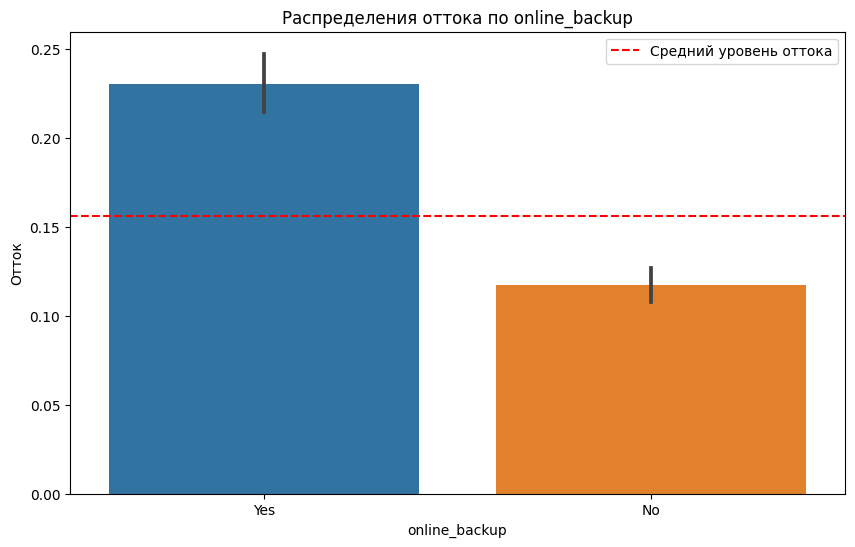

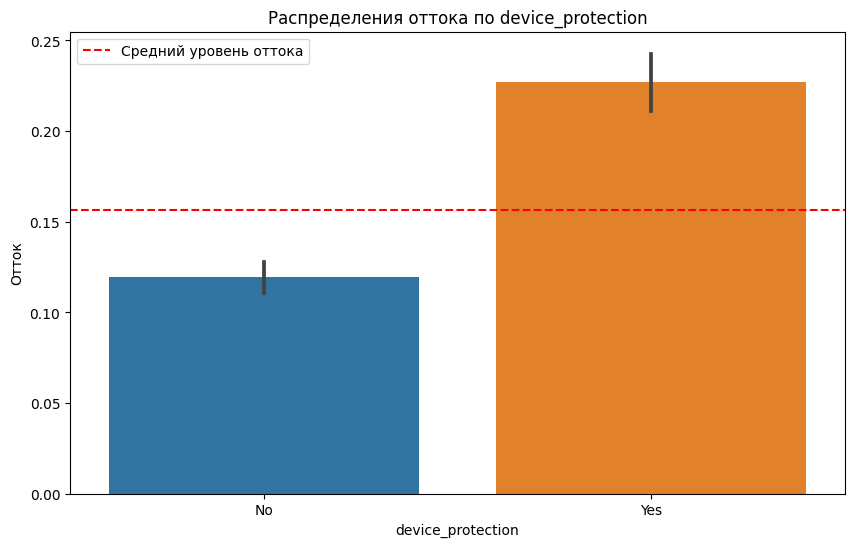

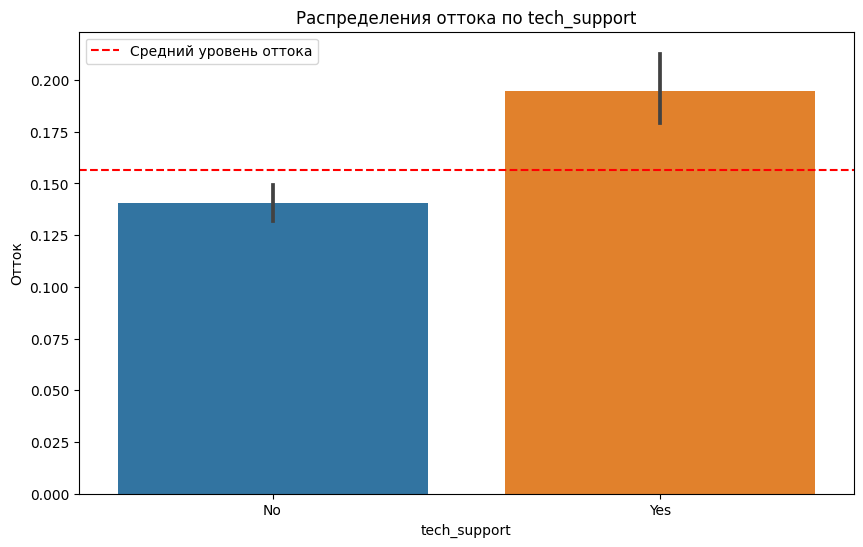

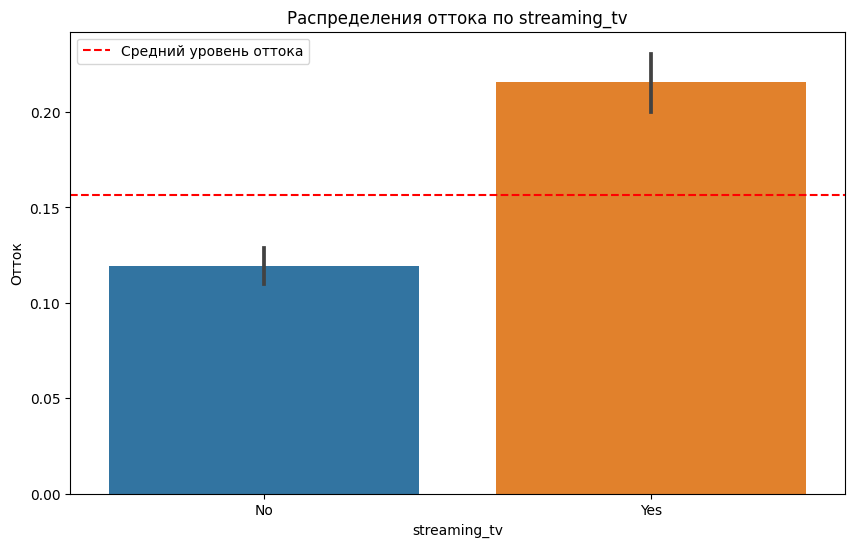

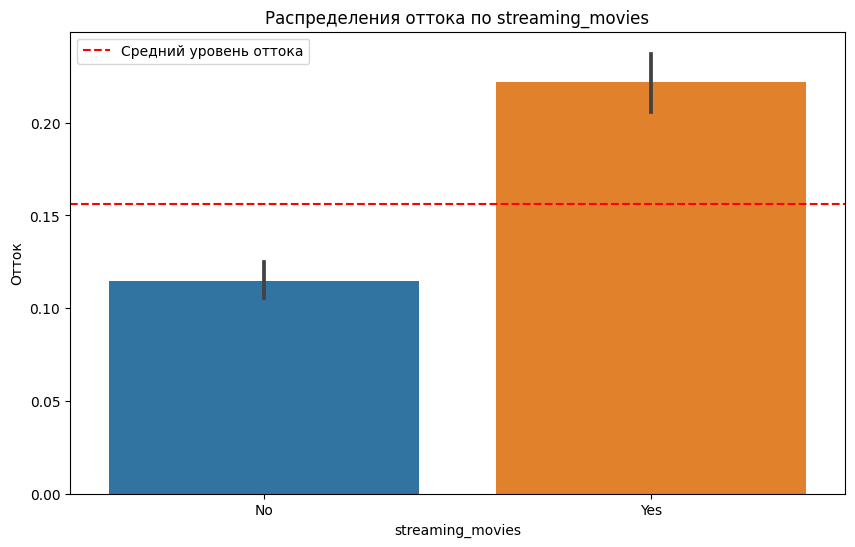

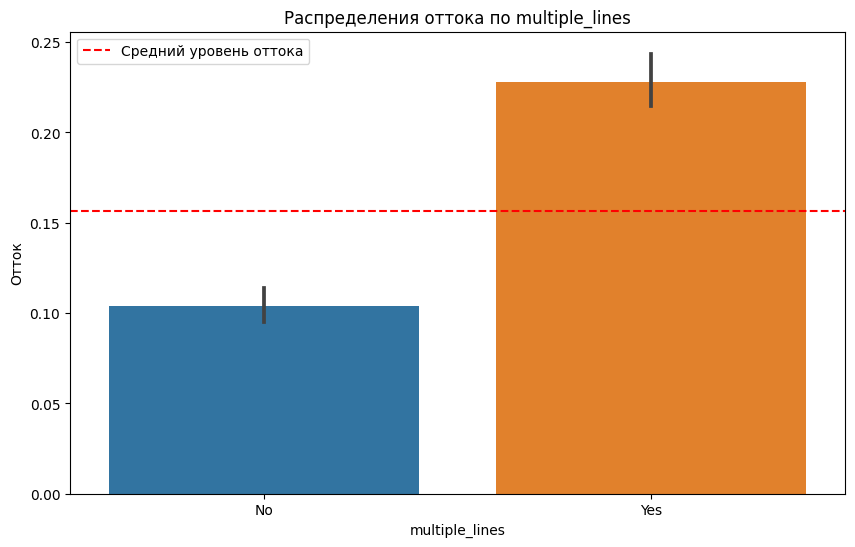

In [31]:
for col in cat_columns:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=col, y='is_churn', data=united_data)
    plt.xlabel(col)
    plt.ylabel('Отток')
    plt.title('Распределения оттока по ' + col)
    
    plt.axhline(united_data['is_churn'].mean(),
                color='r', linestyle='--', label='Средний уровень оттока') 
    plt.legend()
    
    plt.show()

Построим графики распределения по целевому признаку для непрерывных переменных

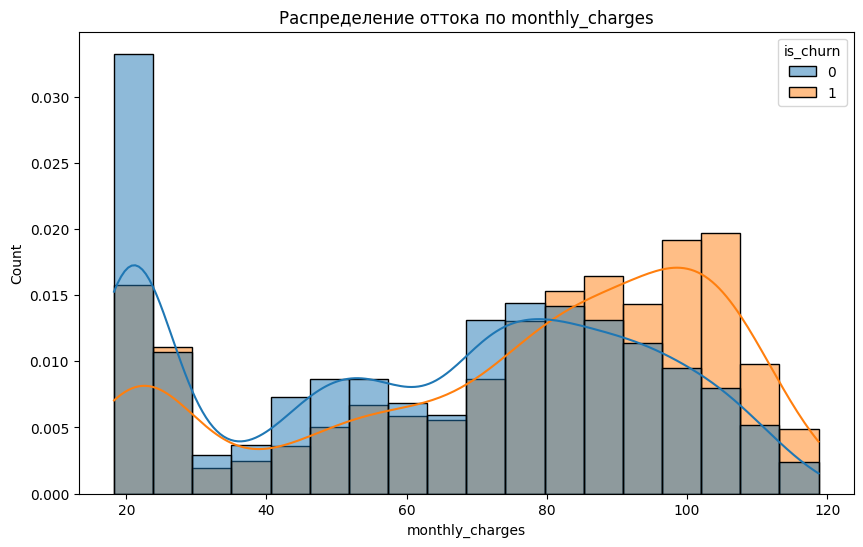

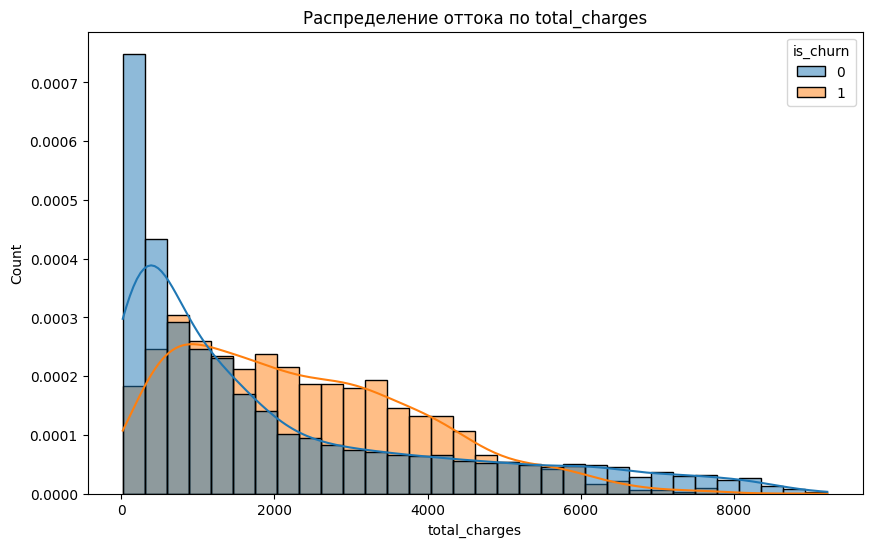

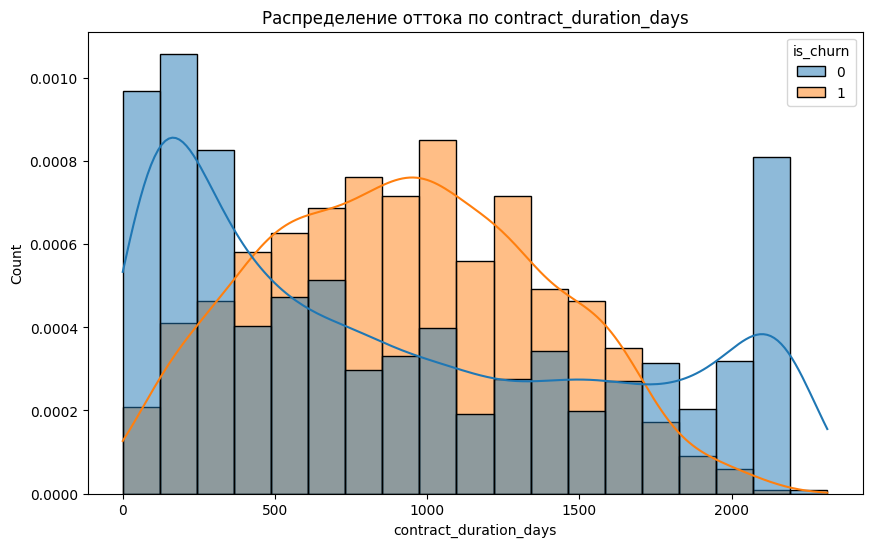

In [32]:
for col in interval_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=united_data, x=col, hue='is_churn', kde=True, stat='density', common_norm=False)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title('Распределение оттока по ' + col)
    plt.show()

При анализе распределения признаков к оттоку сложно сделать какие-то однозначные выводы из графиков или извлечь пользу. Более подробно изучим важность признаков к оттоку на этапе создания модели 

Оценим дисбаланс классов

In [33]:
united_data['is_churn'].value_counts() / len(united_data)

0    0.843675
1    0.156325
Name: is_churn, dtype: float64

Наблюдаем дисбаланс классов в соотношении 85% к 15%. К борьбе с дисбалансом классов уделим внимание на этапе подготовки признаком к обучению модели

# Вывод

В результате исследовательского анализа данных:
- были объединены таблицы в единую по полю`customer_id`
- заполнены пропуски 
- названия колонок приведены к стилю `snake_case`
- изменены типы данных там где это было необходимо 
- добавлены столбцы `is_churn` -  `целевой признак` и  `contract_duration_days` - `количество дней контракта`
- избавились от лишних столбцов: `end_date`, `begin_date`, `gender`, `customer_id`
- построили и визуализировали матрицу корреляций 
- построили графики распределения всех признаков к целевому признаку

Можем приступать к следующему этапу - к подготовке признаков и построению моделей  

# 3. Подготовка признаков

### 3.1 Разделение данных по признакам и на выборки

Для начала зададим константу `RANDOM_STATE`

In [34]:
RANDOM_STATE = 220523

Отделим признаки от целевого признака

In [35]:
features = united_data.drop('is_churn', axis=1)
target = united_data['is_churn']

Разделим на обучающую и тестовую выборку в соотношении 3:1. Из-за малочисленности данных не будем создавать валидационную выборку. Оценивать эффективность обучения модели на этапе построения и выбора будем с помощью кросс-валидации 

In [36]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25,
                                                                            stratify=target,
                                                                            random_state=RANDOM_STATE)

### 3.2 Категоризация и масштабирование признаков

Закодируем наши категориальные признаки с помощью `OrdinalEncoder`

In [37]:
encoder = OrdinalEncoder()
features_train[cat_columns] = encoder.fit_transform(features_train[cat_columns])
features_test[cat_columns] = encoder.transform(features_test[cat_columns])

In [38]:
transformed_train = features_train
transformed_test = features_test

 Используем `StandardScaler` для масштабирования непрерывных числовых переменных 

In [39]:
scaler = StandardScaler()
transformed_train[interval_cols] = scaler.fit_transform(transformed_train[interval_cols])
transformed_test[interval_cols] = scaler.transform(transformed_test[interval_cols])

In [40]:
transformed_train.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_duration_days
5450,0.0,1.0,3.0,0.664236,-0.928781,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.235291
6056,1.0,1.0,1.0,0.213546,0.972768,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.260148
4612,2.0,0.0,3.0,-0.646258,0.390374,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.570432
43,2.0,1.0,1.0,0.504582,1.384659,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.481152
6860,0.0,1.0,0.0,1.237992,-0.060331,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,-0.481537


In [41]:
transformed_test.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_duration_days
4904,0.0,0.0,2.0,1.425918,0.679670,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.146348
4967,0.0,1.0,2.0,-0.035914,-0.885860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,-1.146011
927,0.0,1.0,2.0,0.547821,-0.326570,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-0.567889
2306,0.0,1.0,2.0,0.171969,-0.906633,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.191383
4570,0.0,1.0,3.0,-1.521028,-0.946222,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.011360


Оценим дисбаланс классов для:
- обучающей выборки

In [42]:
target_train.value_counts() / len(target_train)

0    0.84362
1    0.15638
Name: is_churn, dtype: float64

- тестовой выборки

In [43]:
target_test.value_counts() / len(target_test)

0    0.843839
1    0.156161
Name: is_churn, dtype: float64

Убедились что соотношение классов практически не изменилось как для обучающей так и для тестовой

Данные готовы

# Промежуточный вывод

Мы полностью подготовили наши данные для начала обучения моделей, а именно:
- отделили целевой признак
- разделили данные на `train` и `test` в соотношении 3:1
- провели кодирование категориальных и масштабирование непрерывных числовых признаков 
- сбалансировали данные по оттоку для обучающей выборки

# 4. Обучение моделей

### 4.1 RandomForestClassifier

Приступим к обучению моделей. Подберем гиперпараметры для модели `RandomForestClassifier` с помощью `Optuna`

Качество модели при подборе гиперпараметров будем оценивать с помощью кросс-валидации с метрикой `AUC-ROC`

In [44]:
%%time

def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])


    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=RANDOM_STATE
    )


    cv_scores = cross_val_score(model, transformed_train, target_train,
                                cv=4, scoring='roc_auc')


    return cv_scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2023-06-01 02:18:08,430] A new study created in memory with name: no-name-4778eb3a-7694-482f-90f5-9fa878481594
[I 2023-06-01 02:18:17,938] Trial 0 finished with value: 0.8322018303276825 and parameters: {'n_estimators': 800, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.8322018303276825.
[I 2023-06-01 02:18:29,299] Trial 1 finished with value: 0.832505641516102 and parameters: {'n_estimators': 900, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.832505641516102.
[I 2023-06-01 02:18:34,811] Trial 2 finished with value: 0.8331085694711688 and parameters: {'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8331085694711688.
[I 2023-06-01 02:18:37,432] Trial 3 finished with value: 0.8323931017008795 and parameters: {'n_estimators': 200, 'max_depth': 9, 'min_sa

CPU times: total: 5min 23s
Wall time: 5min 24s


In [45]:
trial = study.best_trial
print('Модель - Случайный лес')
print('AUC-ROC:', trial.value)
print('Гиперпараметры модели:', trial.params)

Модель - Случайный лес
AUC-ROC: 0.8368947416750219
Гиперпараметры модели: {'n_estimators': 700, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


Случайный лес:
- среднее значение `AUC-ROC` при кросс-валидации - `83,7`
- `время подбора` гиперпараметров около `8 минут`

### 4.2 CatBoostClassifier

Подберем гиперпараметры для `CatBoostClassifier`

Инициализируем сетку для грида, начальные параметры CatBoost, и параметры GridSearchCV с `scoring='roc_auc'`

In [46]:
param_grid = {'learning_rate': [0.01, 0.05, 0.07, 0.08, 0.09, 0.1]}

model = CatBoostClassifier(verbose=500, iterations=1000, random_state=RANDOM_STATE)

grid_search = GridSearchCV(model, param_grid=param_grid, cv=4, scoring='roc_auc')

In [47]:
%%time
grid_search.fit(transformed_train, target_train)

0:	learn: 0.6840069	total: 135ms	remaining: 2m 14s
500:	learn: 0.2782618	total: 1.15s	remaining: 1.14s
999:	learn: 0.2376206	total: 2.17s	remaining: 0us
0:	learn: 0.6839088	total: 2.28ms	remaining: 2.28s
500:	learn: 0.2807744	total: 1.01s	remaining: 1s
999:	learn: 0.2404264	total: 2s	remaining: 0us
0:	learn: 0.6837042	total: 2.1ms	remaining: 2.09s
500:	learn: 0.2791108	total: 995ms	remaining: 991ms
999:	learn: 0.2394462	total: 1.99s	remaining: 0us
0:	learn: 0.6839632	total: 2.06ms	remaining: 2.06s
500:	learn: 0.2813396	total: 984ms	remaining: 980ms
999:	learn: 0.2420216	total: 2s	remaining: 0us
0:	learn: 0.6490226	total: 2.56ms	remaining: 2.56s
500:	learn: 0.1500387	total: 1.06s	remaining: 1.05s
999:	learn: 0.0887055	total: 2.15s	remaining: 0us
0:	learn: 0.6485482	total: 2.46ms	remaining: 2.46s
500:	learn: 0.1525780	total: 1.05s	remaining: 1.05s
999:	learn: 0.0895621	total: 2.05s	remaining: 0us
0:	learn: 0.6476488	total: 2.06ms	remaining: 2.06s
500:	learn: 0.1563460	total: 995ms	remain

GridSearchCV(cv=4,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000179414E1910>,
             param_grid={'learning_rate': [0.01, 0.05, 0.07, 0.08, 0.09, 0.1]},
             scoring='roc_auc')

In [48]:
print('Лучшие параметры', grid_search.best_params_)
print('AUC-ROC', grid_search.best_score_)

Лучшие параметры {'learning_rate': 0.09}
AUC-ROC 0.9065227632722249


CatBoost:
- среднее значение `AUC-ROC` при кросс-валидации - `90.6`
- `время подбора` гиперпараметров около `1 минуты` (подбирался только `learning_rate` под 1000 итераций)

# Промежуточный вывод

Были подобраны гиперпараметры для двух моделей:
- `RandomForestClassifier` с помощью `Optuna`
- `CatBoostClassifier` с помощью `GridSearch`

`AUC-ROC:`
- RandomForestClassifier - `83,7`
- **CatBoostClassifier - `90.6`**

Лучшей моделью для итогового тестирования выбираем `CatBoostClassifier`

In [49]:
best_model = CatBoostClassifier(iterations=1000, learning_rate=0.09, verbose=500, random_state=RANDOM_STATE)

Обучим лучшую модель на обучающей выборке

In [50]:
best_model.fit(transformed_train, target_train)

0:	learn: 0.6173627	total: 2.77ms	remaining: 2.76s
500:	learn: 0.1114958	total: 1.24s	remaining: 1.23s
999:	learn: 0.0573740	total: 2.52s	remaining: 0us


Можно приступать к тестированию выбранной модели

# 5 Итоговое тестирование

Запускаем нашу модель на тестовых данных

In [51]:
proba = best_model.predict_proba(transformed_test)[:, 1]

auc_roc = roc_auc_score(target_test, proba)

In [52]:
predict = best_model.predict(transformed_test)

accuracy = accuracy_score(target_test, predict)

In [53]:
print(f'Accuracy на тестовой выборке: {accuracy:.2f}')

Accuracy на тестовой выборке: 0.92


In [54]:
print(f'AUC-ROC на тестовой выборке: {auc_roc:.2f}')

AUC-ROC на тестовой выборке: 0.92


Построим график AUC-ROC для тестовой выборки

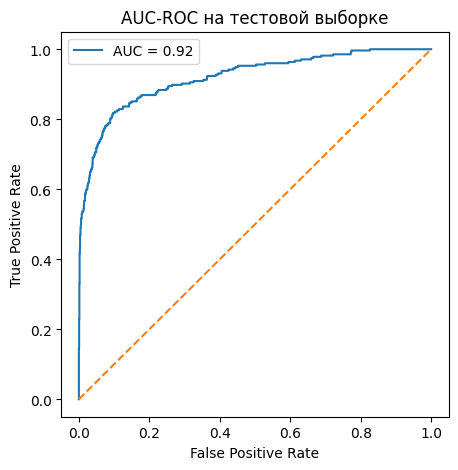

In [55]:
fpr, tpr, _ = roc_curve(target_test, proba)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC на тестовой выборке')
plt.legend()
plt.show()

Невозможно будет оценить AUC-ROC константной модели ввиду предсказаний только одним классом. Для сравнения будем использовать случайную модель 

In [56]:
random_model_predict = pd.Series(np.random.choice([0, 1], size=len(target_test)), index=target_test.index)

In [57]:
print(f'Accuracy случайной модели: {accuracy_score(random_model_predict, target_test):.2f}')

Accuracy случайной модели: 0.51


In [58]:
print(f'AUC-ROC случайной модели: {roc_auc_score(random_model_predict, target_test):.2f}')

AUC-ROC случайной модели: 0.51


**Accuracy и AUC-ROC** случайной модели около - `0,5`

Оценим важность признаков нашей модели и построим график для лучшего восприятия

In [59]:
feature_importance = best_model.get_feature_importance()
feature_names = best_model.feature_names_

In [60]:
data = pd.Series(feature_importance, index=feature_names).sort_values(ascending=False)

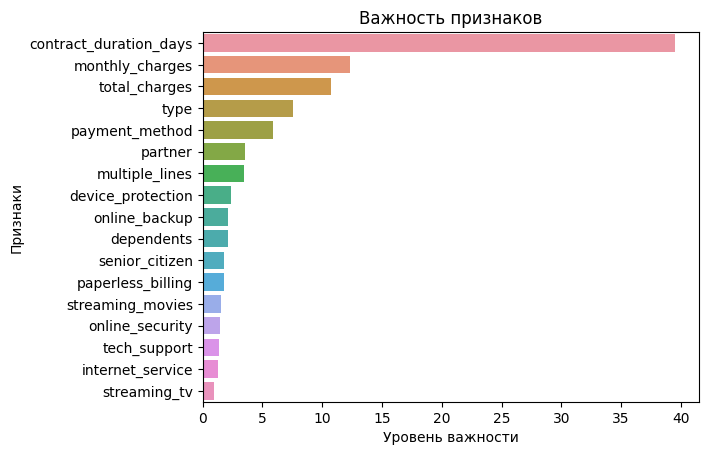

In [61]:
sns.barplot(y=data.index, x=data.values, orient='horizontal')
plt.xlabel('Уровень важности')
plt.ylabel('Признаки')
plt.title('Важность признаков')
plt.show()

Самой важный  признак, больше всего повлиявший на предсказания модели, с огромным отрывом оказался `contract_duration_days` (продолжительность контракта в днях) 

Построим матрицу ошибок `confusion_matrix`

In [62]:
confusion = confusion_matrix(target_test, predict)
tn, fp, fn, tp = confusion.ravel()

matrix = {'Предсказанный "Positive"': [tp, fp], 'Предсказанный "Negative"': [fn, tn]}
index = ['Истинный "Positive"', 'Истинный "Negative"']
matrix = pd.DataFrame(matrix, index=index)

matrix

,"Предсказанный ""Positive""","Предсказанный ""Negative"""
"Истинный ""Positive""",161,114
"Истинный ""Negative""",26,1460


Из данных таблицы можно сделать следующие выводы:
- верные положительные (True Positive, TP): В данной матрице 161 клиент был правильно классифицирован как "Отток". Это означает, что правильно идентифицировали клиентов, которые действительно собираются уйти

- ложные положительные (False Positive, FP): В матрице 114 клиентов были неправильно классифицированы как "Отток". Это означает, что мы ошибочно отнесли некоторых клиентов к категории "Отток". Это может привести к ненужным затратам или мерам удержания, которые могут быть нецелесообразными

- ложные отрицательные (False Negative, FN): В матрице 26 клиентов были неправильно классифицированы как "Не отток". Это означает, что мы пропустили или не распознали некоторых клиентов, которые собираются уйти. Это потенциально упущенные возможности для удержания клиентов и предотвращения оттока

- верные отрицательные (True Negative, TN): В данной матрице 1460 клиентов были правильно классифицированы как "Не отток". Это означает, что мы правильно идентифицировали клиентов, которые остаются с нами и не собираются уходить.

Из этих выводов можно сделать следующие наблюдения:
- модель достаточно точно определяет клиентов, которые остаются с нами, с высоким значением TN (1460).
- модель имеет некоторое количество ложных срабатываний, что означает, что мы можем направить ненужные меры по удержанию некоторых клиентов.
- также модель пропускает некоторых клиентов, которые фактически собираются уйти (ложные отрицательные), что может привести к потере возможностей для удержания или предотвращения оттока.

# Вывод

На этапе подбора модели были обучены две:
- `RandomForest` с `AUC-ROC = 83,7`
- **`CatBoost` с `AUC-ROC = 90.6`**

Лучшей моделью выбрана `CatBoostClassifier` с гиперпараметрами:
- **iterations = 1000**
- **learning_rate = 0.09**
- **random_state = 220523**

На **`тестовой выборке`** модель показала:
- **`AUC-ROC = 92`**
- **`Accuracy = 92`**

Сравнили показатели со случайной моделью 

Был проведен анализ важности признаков. Ключевым признаком влияющим на принятия решений модели **`contract_duration_days`** (продолжительность контракта в днях)

Так же представлена матрица ошибок с пояснениями

Более подробный отчет о выполненной работе будет представлен на следующем этапе

# Отчёт 

## Изначальный план проекта

1. Загрузка и первичный осмотр данных
    - загрузка и осмотр данных методами библиотеки pandas
    - описание выводов
2. Исследовательский анализ данных
    - Предобработка данных
        - объединение таблиц в единую 
        - заполнение пропусков 
        - анализ некорректных данных
        - приведение столбцов к корректному типу данных  
        - добавление признаков (в том числе целевого признака)
        - удаление лишних признаков
    - Построение графиков и матрицы корреляции
        - построение графиков и матриц 
        - написание выводов к результатам
3. Обучение модели
    - Подготовка признаков
        - разделение на признаки и целевой признак
        - разделение данных на выборки 
        - кодировка категориальных признаков
        - масштабирование признаков (при необходимости)
        - борьба с дисбалансом
    - Обучение моделей
        - подбор гиперпараметров с помощью GridSearchCV, RandomizedSearchCV или Optuna
        - обучение нескольких моделей 
        - выявление лучшей модели с помощью кросс-валидации 
4. Тестирование модели
    - итоговое тестирование лучшей модели на тестовой выборке 
    - сравнение результатов со случайными или статичными моделями
    - подведение итогов и написание общего вывода
5. Подготовка отчета для бизнеса

Фактически были выполнены все пункты из изначального плана проекта, кроме балансировки классов. Необходимости в балансировке классов не было, в связи с тем что ключевая метрика `AUC-ROC` не чувствительна к дисбалансу классов. На этапе тестирования модели дополнительно оценили важность признаков и построили матрицу ошибок модели.

## Список признаков 

Конечный список признаков участвующий в обучении модели:
 
- `Type` - тип оплаты: ежемесячный, годовой и т.д.
- `PaperlessBilling` - электронный платежный документ
- `PaymentMethod` - способ оплаты
- `MonthlyCharges` - ежемесячные траты на услуги по договору
- `TotalCharges` - всего потрачего денег на услуги
- `Dependents` - наличие иждивенцев
- `Senior Citizen` - наличие пенсионного статуса по возрасту
- `Partner` - наличие супруга
- `MultipleLines` - наличие возможности ведения параллельных линий во время звонка
- `Contract Duration Days` - продолжительность контракта с пользователем в днях

Так же признаки обозначающие наличие той или иной услуги в контракте с пользователем: 
- `internet_service`
- `online_security`
- `online_backup`
- `device_protection` 
- `tech_support`
- `streaming_tv`
- `streaming_movies`


Проводилось масштабирование признаков: `MonthlyCharges`, `TotalCharges`, `Contract Duration Days`

Так же кодирование категориальных признаков (всех остальных)

## Предобработка данных

В изначальных данных отсутствовали пропуски и дубликаты. Пропуски образовались после объединения всех данных в единую таблицу. Причина пропусков заключалась в отсутствии у конкретного пользователя той или иной функции/опции в контракте. Пропуски были обработаны в соответствии с причиной их появления

В столбце `TotalCharges` были замечены аномальные (пустые) значения. Данные были восстановлены из столбца `MonthlyCharges`, после чего столбец был приведен к числовому типу данных

С помощью столбца `End Date` был сформирован целевой признак. После `End Date` и `Begin Date` привели к типу `datetime`. Сформировали с помощью них важный признак `Contract Duration`. Далее столбцы `End Date` и `Begin Date` были удалены

## Модели

В проекте подбирали параметры и обучали две модели с ниже представленными значениями метрики при кросс-валидации: 

**RandomForestClassifier**
- время подбора гиперпараметров `8-10 минут`
- `AUC-ROC: 83.7` 

**CatBoostClassifier**
- время подбора около `1 минуты` 
- `AUC-ROC: 90.6`

## Лучшая модель

Лучшей моделью, выбранной для финального тестирования, стала **`CatBoostClassifier`** с `AUC-ROC` на кросс-валидации = `90.6`  и с гиперпараметрами: `iterations=1000, learning_rate=0.09, random_state=220523`


## Результаты модели на тестовой выборке

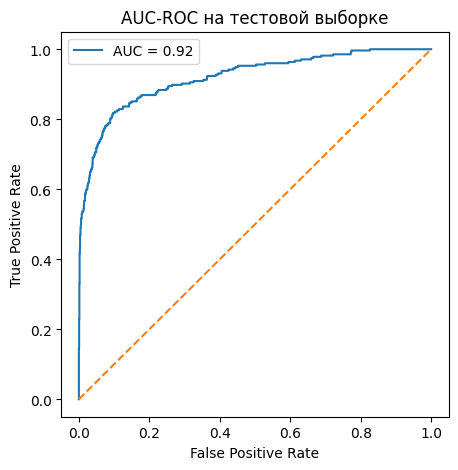

In [63]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC на тестовой выборке')
plt.legend()
plt.show()

- `AUC-ROC` на тестовой выборке = `0.92` (указывает на высокую предсказательную способность модели и её способность различать между классами

- `Accuracy` на тестовой выборке = `0.92` (указывает на то, что модель правильно классифицирует 92%  входных данных)

## Важность признаков

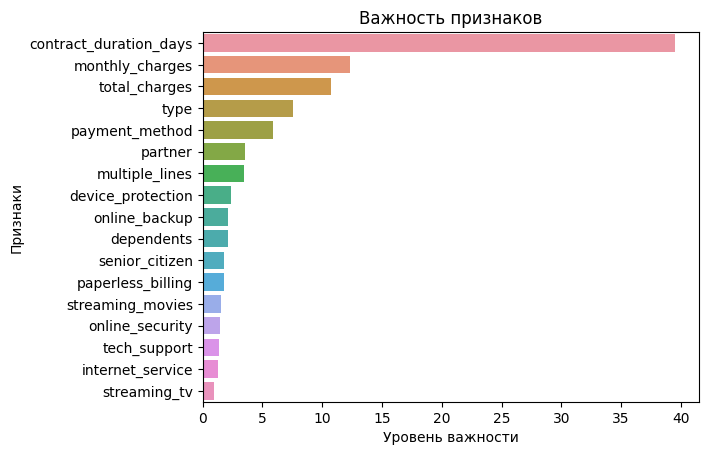

In [64]:
sns.barplot(y=data.index, x=data.values, orient='horizontal')
plt.xlabel('Уровень важности')
plt.ylabel('Признаки')
plt.title('Важность признаков')
plt.show()

На графике представлены признаки отсортированные по важности (сверху вниз). Соответственно основные признаки влияющие на принятия решения модели это `Contract Duration`, `Monthly Charges`, `Total Charges`. 

Признаки меньше всего повлиявшие на решения модели `Tech Support`, `Internet Service`, `Streaming TV`

## Матрица ошибок

In [65]:
matrix

,"Предсказанный ""Positive""","Предсказанный ""Negative"""
"Истинный ""Positive""",161,114
"Истинный ""Negative""",26,1460


Из данных таблицы можно сделать следующие выводы:
- верные положительные (True Positive, TP): В данной матрице 161 клиент был правильно классифицирован как "Отток". Это означает, что правильно идентифицировали клиентов, которые действительно собираются уйти

- ложные положительные (False Positive, FP): В матрице 114 клиентов были неправильно классифицированы как "Отток". Это означает, что мы ошибочно отнесли некоторых клиентов к категории "Отток". Это может привести к ненужным затратам или мерам удержания, которые могут быть нецелесообразными

- ложные отрицательные (False Negative, FN): В матрице 26 клиентов были неправильно классифицированы как "Не отток". Это означает, что мы пропустили или не распознали некоторых клиентов, которые собираются уйти. Это потенциально упущенные возможности для удержания клиентов и предотвращения оттока

- верные отрицательные (True Negative, TN): В данной матрице 1460 клиентов были правильно классифицированы как "Не отток". Это означает, что мы правильно идентифицировали клиентов, которые остаются с нами и не собираются уходить.

Из этих выводов можно сделать следующие наблюдения:
- модель достаточно точно определяет клиентов, которые остаются с нами, с высоким значением TN (1460).
- модель имеет некоторое количество ложных срабатываний, что означает, что мы можем направить ненужные меры по удержанию некоторых клиентов.
- также модель пропускает некоторых клиентов, которые фактически собираются уйти (ложные отрицательные), что может привести к потере возможностей для удержания или предотвращения оттока.

## Сложности и пути решения

Во время работы над проектом было принято решение кодировать данные с помощью `get_dummies`, так же сбалансировать классы обучающей выборки что привело к снижению `AUC-ROC` на тестовой выборке. Изменили подход к кодированию категориальных переменных и отказались от балансировки классов, что привело к увеличению `AUC-ROC` на тестовой выборке с `87` до `92`. Других сложностей при написании проекта не возникло